#**Feedforward Network**


In [ ]:
!pip install scikit-learn==1.1.0 scikeras==0.6.0


ERROR: Ignored the following versions that require a different python version: 0.2.0 Requires-Python >=3.6.7,<3.9; 0.2.1 Requires-Python >=3.6.7,<3.9; 0.6.0 Requires-Python >=3.7.0,<3.10.0; 0.6.1 Requires-Python >=3.7.0,<3.10.0; 0.7.0 Requires-Python >=3.7.0,<3.10.0
ERROR: Could not find a version that satisfies the requirement scikeras==0.6.0 (from versions: 0.1.6, 0.1.7, 0.1.8, 0.3.0, 0.3.1, 0.3.3, 0.4.0, 0.4.1, 0.8.0, 0.9.0, 0.10.0, 0.11.0, 0.12.0, 0.13.0)
ERROR: No matching distribution found for scikeras==0.6.0


Number of features in dataset 8
Selected feature indices: [0 1 5 6 7]
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Average MSE across 10 folds: 0.4794


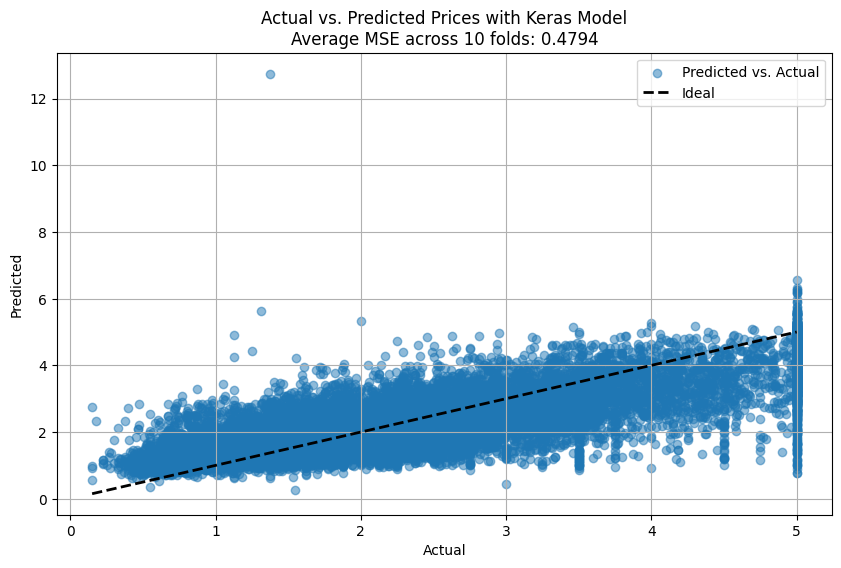

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


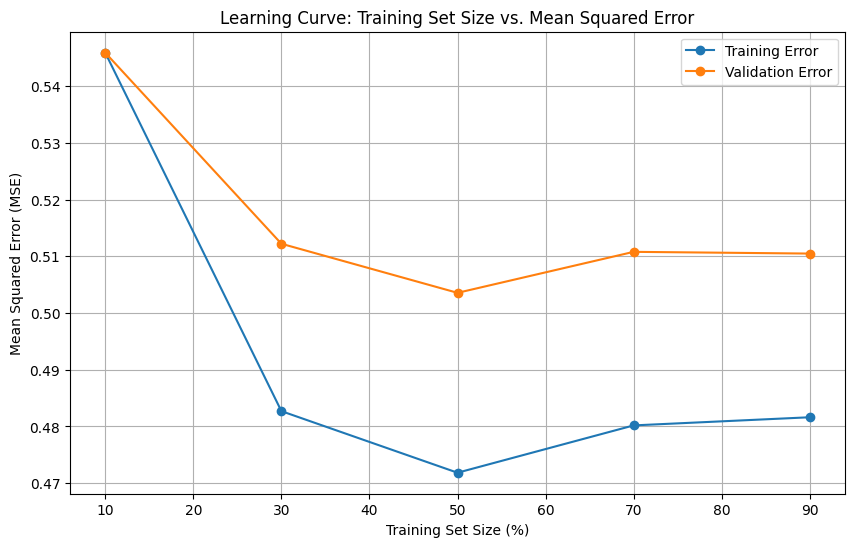

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the California housing dataset
X, y = fetch_california_housing(return_X_y=True)

# Define the number of top features to select
print("Number of features in dataset", X.shape[1])
num_features = 5

# Create a base model for RFE
base_model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)

# Apply RFE to select the top num_features
rfe = RFE(estimator=base_model, n_features_to_select=num_features)
rfe.fit(X, y)

# Get the selected features
selected_features = np.where(rfe.support_)[0]
print(f"Selected feature indices: {selected_features}")

# Transform the dataset to only include the selected features
X_rfe = rfe.transform(X)

# Define a function to create the Keras model
def create_model(learning_rate=0.01):
    model = Sequential([
        Input(shape=(X_rfe.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)  # Single output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

# Initialize 10-fold cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_scores = []
all_y_actual = []
all_y_pred = []

# Perform cross-validation
for train_index, val_index in kf.split(X_rfe):
    X_train, X_val = X_rfe[train_index], X_rfe[val_index]
    y_train, y_val = y[train_index], y[val_index]

    # Create and train the model
    model = create_model(learning_rate=0.01)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Predict on validation set
    y_val_pred = model.predict(X_val).flatten()
    mse = mean_squared_error(y_val, y_val_pred)
    mse_scores.append(mse)
    all_y_actual.extend(y_val)
    all_y_pred.extend(y_val_pred)

# Report average MSE across 10 folds
average_mse = np.mean(mse_scores)
print(f"Average MSE across 10 folds: {average_mse:.4f}")

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(all_y_actual, all_y_pred, alpha=0.5, label='Predicted vs. Actual')
plt.plot([min(all_y_actual), max(all_y_actual)], [min(all_y_actual), max(all_y_actual)], 'k--', lw=2, label='Ideal')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Prices with Keras Model\nAverage MSE across 10 folds: {average_mse:.4f}')
plt.legend()
plt.grid()
plt.show()

# Define training sizes for the learning curve
training_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]

mse_train = []
mse_val = []

# Loop over different training set sizes
for frac in training_sizes:
    # Create a subset of the training data
    X_train_subset, _, y_train_subset, _ = train_test_split(X_rfe, y, train_size=frac, random_state=42)

    # Create and train the model
    model = create_model(learning_rate=0.01)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        X_train_subset, y_train_subset,
        validation_data=(X_val, y_val),
        epochs=200,
        batch_size=32,
        callbacks=[early_stopping],
        verbose=0
    )

    # Evaluate the model on the training and validation sets
    y_train_pred = model.predict(X_train_subset).flatten()
    y_val_pred = model.predict(X_val).flatten()

    mse_train.append(mean_squared_error(y_train_subset, y_train_pred))
    mse_val.append(mean_squared_error(y_val, y_val_pred))

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(np.array(training_sizes) * 100, mse_train, label='Training Error', marker='o')
plt.plot(np.array(training_sizes) * 100, mse_val, label='Validation Error', marker='o')
plt.title('Learning Curve: Training Set Size vs. Mean Squared Error')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid()
plt.show()


Number of features in dataset 8
Selected feature indices: [0 1 5 6 7]
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: learning_rate=0.001, batch_size=16, epochs=100, Average MSE=0.4496
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: learning_rate=0.001, batch_size=16, epochs=200, Average MSE=0.5524
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: learning_rate=0.001, batch_size=32, epochs=100, Average MSE=0.5269
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: learning_rate=0.001, batch_size=32, epochs=200, Average MSE=0.4600
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Params: learnin

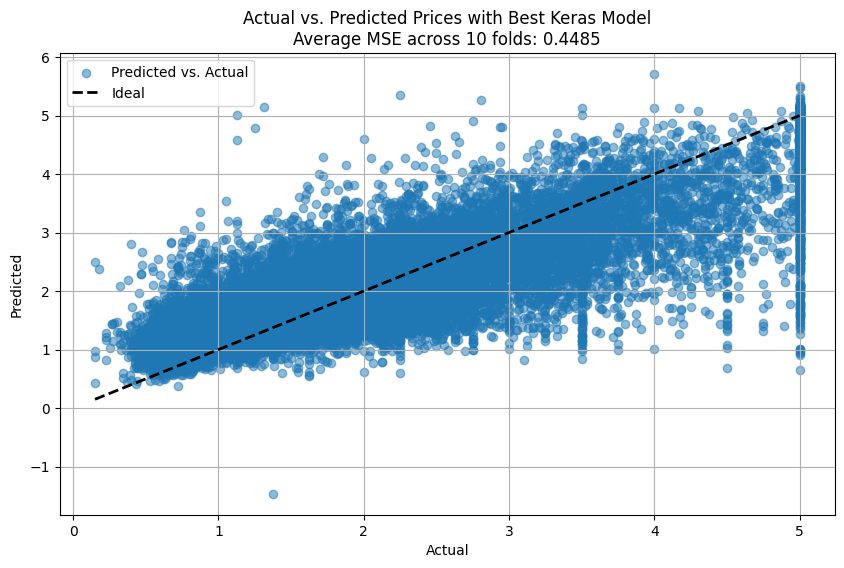

65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
194/194 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
323/323 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
452/452 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
581/581 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
215/215 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


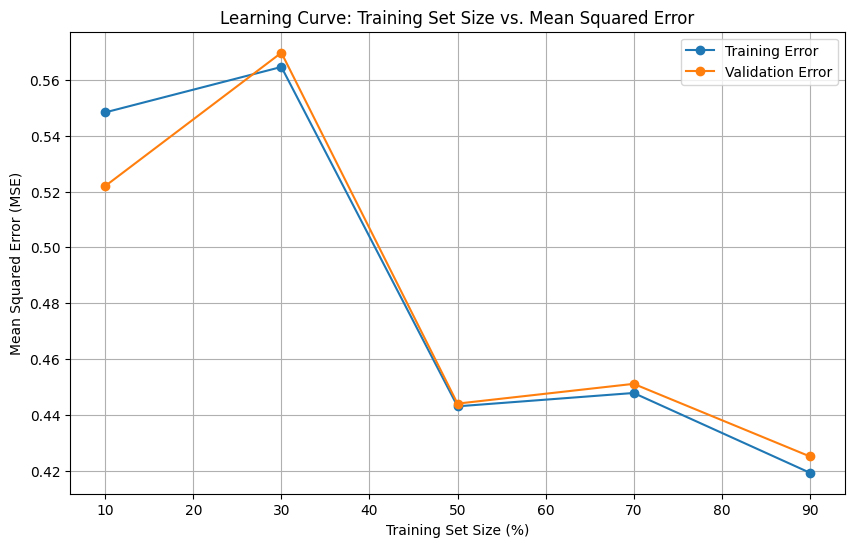

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from sklearn.datasets import fetch_california_housing
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from itertools import product

# Load the California housing dataset
X, y = fetch_california_housing(return_X_y=True)

# Define the number of top features to select
print("Number of features in dataset", X.shape[1])
num_features = 5

# Create a base model for RFE
base_model = RandomForestRegressor(random_state=42, n_estimators=100, max_depth=10)

# Apply RFE to select the top num_features
rfe = RFE(estimator=base_model, n_features_to_select=num_features)
rfe.fit(X, y)

# Get the selected features
selected_features = np.where(rfe.support_)[0]
print(f"Selected feature indices: {selected_features}")

# Transform the dataset to only include the selected features
X_rfe = rfe.transform(X)

# Define a function to create the Keras model
def create_model(learning_rate=0.01):
    model = Sequential([
        Input(shape=(X_rfe.shape[1],)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1)  # Single output for regression
    ])
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
    return model

# Hyperparameter grid
param_grid = {
    'learning_rate': [0.001, 0.01],
    'batch_size': [16, 32],
    'epochs': [100, 200]
}

# Hyperparameter tuning
best_params = None
best_mse = float('inf')

for learning_rate, batch_size, epochs in product(param_grid['learning_rate'], param_grid['batch_size'], param_grid['epochs']):
    kf = KFold(n_splits=3, shuffle=True, random_state=42)
    mse_scores = []

    for train_index, val_index in kf.split(X_rfe):
        X_train, X_val = X_rfe[train_index], X_rfe[val_index]
        y_train, y_val = y[train_index], y[val_index]

        model = create_model(learning_rate=learning_rate)
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=0
        )
        y_val_pred = model.predict(X_val).flatten()
        mse_scores.append(mean_squared_error(y_val, y_val_pred))

    average_mse = np.mean(mse_scores)
    print(f"Params: learning_rate={learning_rate}, batch_size={batch_size}, epochs={epochs}, Average MSE={average_mse:.4f}")

    if average_mse < best_mse:
        best_mse = average_mse
        best_params = {'learning_rate': learning_rate, 'batch_size': batch_size, 'epochs': epochs}

print(f"Best parameters: {best_params}")

# Train the best model
kf = KFold(n_splits=3, shuffle=True, random_state=42)
mse_scores = []
all_y_actual = []
all_y_pred = []

for train_index, val_index in kf.split(X_rfe):
    X_train, X_val = X_rfe[train_index], X_rfe[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model(learning_rate=best_params['learning_rate'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        callbacks=[early_stopping],
        verbose=0
    )
    y_val_pred = model.predict(X_val).flatten()
    mse_scores.append(mean_squared_error(y_val, y_val_pred))
    all_y_actual.extend(y_val)
    all_y_pred.extend(y_val_pred)

# Report average MSE across 10 folds
average_mse = np.mean(mse_scores)
print(f"Average MSE across 10 folds with best parameters: {average_mse:.4f}")

# Plot Actual vs. Predicted Prices
plt.figure(figsize=(10, 6))
plt.scatter(all_y_actual, all_y_pred, alpha=0.5, label='Predicted vs. Actual')
plt.plot([min(all_y_actual), max(all_y_actual)], [min(all_y_actual), max(all_y_actual)], 'k--', lw=2, label='Ideal')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Prices with Best Keras Model\nAverage MSE across 10 folds: {average_mse:.4f}')
plt.legend()
plt.grid()
plt.show()

# Define training sizes for the learning curve
training_sizes = [0.1, 0.3, 0.5, 0.7, 0.9]

mse_train = []
mse_val = []

# Loop over different training set sizes
for frac in training_sizes:
    X_train_subset, _, y_train_subset, _ = train_test_split(X_rfe, y, train_size=frac, random_state=42)

    model = create_model(learning_rate=best_params['learning_rate'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    model.fit(
        X_train_subset, y_train_subset,
        validation_data=(X_val, y_val),
        epochs=best_params['epochs'],
        batch_size=best_params['batch_size'],
        callbacks=[early_stopping],
        verbose=0
    )
    y_train_pred = model.predict(X_train_subset).flatten()
    y_val_pred = model.predict(X_val).flatten()

    mse_train.append(mean_squared_error(y_train_subset, y_train_pred))
    mse_val.append(mean_squared_error(y_val, y_val_pred))

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.plot(np.array(training_sizes) * 100, mse_train, label='Training Error', marker='o')
plt.plot(np.array(training_sizes) * 100, mse_val, label='Validation Error', marker='o')
plt.title('Learning Curve: Training Set Size vs. Mean Squared Error')
plt.xlabel('Training Set Size (%)')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid()
plt.show()